## Table of Contents

  - 1. Importing libraries and data
  - 2. Data selection and cleaning
  - 3. Time-series analysis: decomposition
  - 4. Testing for stationarity

## 1. Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
path = r'INSERT-YOUR-PATH'

In [3]:
#Importing data as df
df = pd.read_pickle(os.path.join(path, '01 Data', 'Prepared Data', 'dataset_08-23_2024-12-13.pkl'))

In [4]:
df.head()

,Country,Year,Happiness,GDP_log,Social_support,Life_expectancy,Freedom,Generosity,Corruption,Pos_affect,Neg_affect,Democracy,Inflation,_merge
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258,3.02,26.418664,both
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237,NaN,NaN,left_only
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275,2.48,2.178538,both
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267,2.48,11.804186,both
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268,2.48,6.441213,both


In [6]:
df.shape

(2145, 14)

## 2. Data selection and cleaning

In [7]:
df.columns

Index(['Country', 'Year', 'Happiness', 'GDP_log', 'Social_support',
       'Life_expectancy', 'Freedom', 'Generosity', 'Corruption', 'Pos_affect',
       'Neg_affect', 'Democracy', 'Inflation', '_merge'],
      dtype='object')

In [16]:
# Mean of happiness scores by year
yearly_happiness = df.groupby('Year')['Happiness'].mean().to_frame()

In [17]:
yearly_happiness.head()

,Happiness
Year,
2008,5.418509
2009,5.457667
2010,5.496806
2011,5.424082
2012,5.443617


In [19]:
type(yearly_happiness)

pandas.core.frame.DataFrame

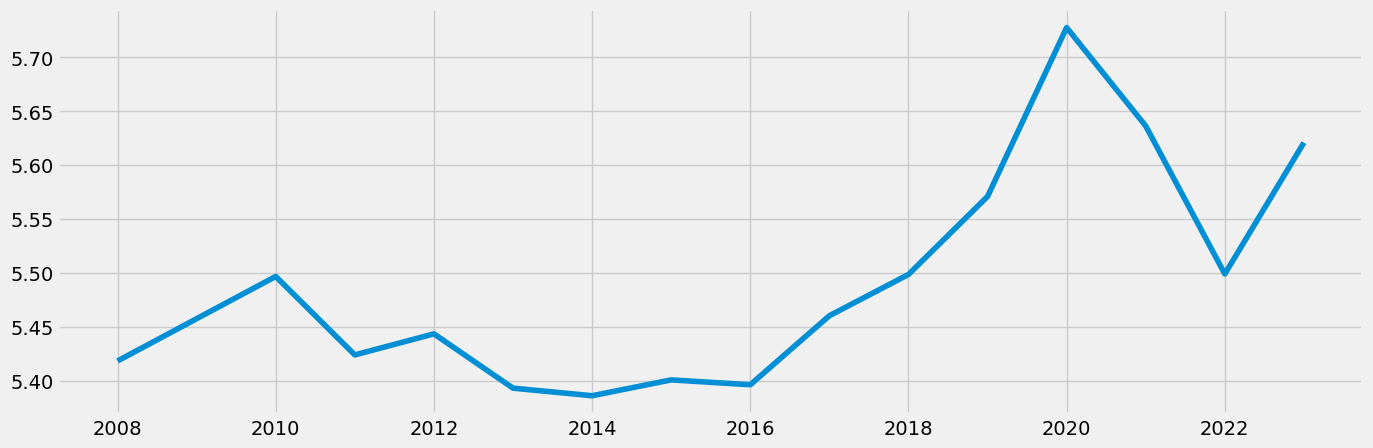

In [33]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(yearly_happiness)

**Observation**: The data does not show signs of seasonality. Overall happiness is higher post 2016 than pre-2016 but ir is unclear whether this an actual trend or not since values went down sharply in 2021 and 2022. The drop seems to coincide with the COVID-pandemic, which is interesting because the World Happiness Report stated that COVID had no strong effect on global happiness.

In [34]:
# Check for missing values (you shouldn't have any)

yearly_happiness.isnull().sum() 

Happiness    0
dtype: int64

In [35]:
# Check for duplicates

dups = yearly_happiness.duplicated()
dups.sum()

# No d

0

## 3. Time-series analysis: decomposition

In [37]:
yearly_happiness.index = pd.to_datetime(yearly_happiness.index, format='%Y')

In [38]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(yearly_happiness, model='additive')

In [39]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

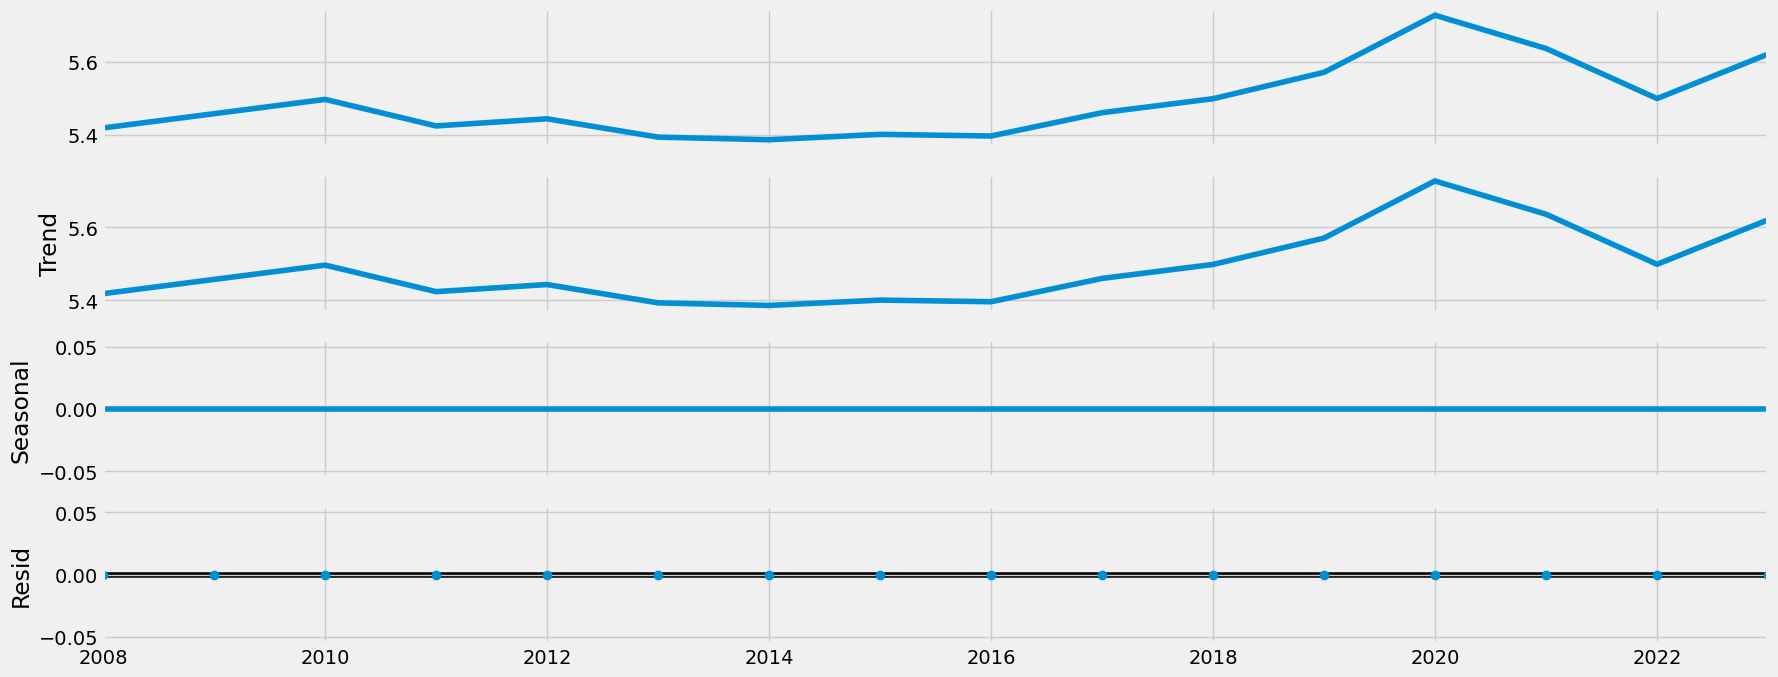

In [40]:
# Plot the separate components

decomposition.plot()
plt.show()

**Observation**: No seasonality, no noise and a very weak upwards trend. Stationarity is not clear at this point.

## 4. Testing for stationarity

In [42]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(yearly_happiness['Happiness'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.509956
p-value                         0.007735
Number of Lags Used             5.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


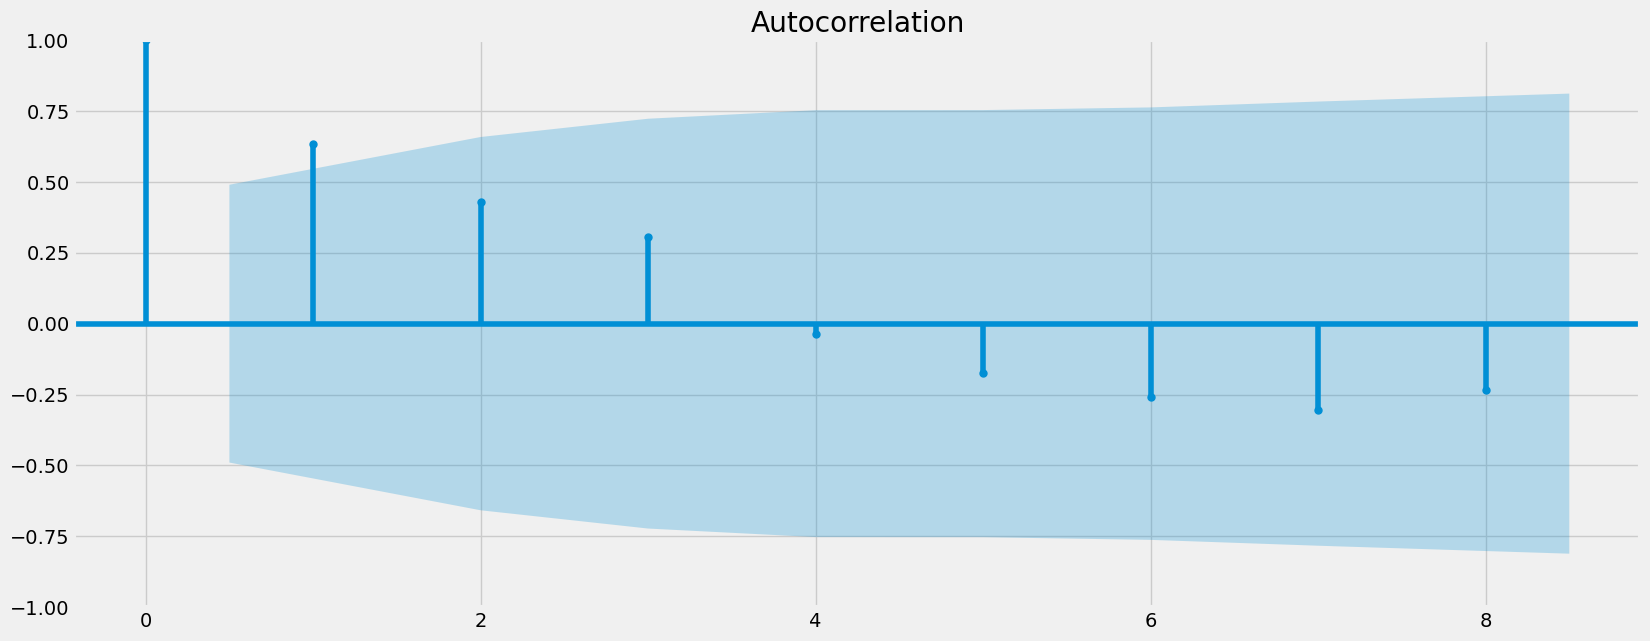

In [43]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(yearly_happiness)
plt.show()

**Observation**: "Test Statistic" of -3.509 is lower than "Critical Value (5%)" of -3.232950. This means that World Happiness Report dataset is stationary. The autocorrelation plot supports this assumption. This means we would not have to conduct additional steps to stationarize the time series data but could use it for forecasting.